In [10]:
import gymnasium as gym
from tqdm import tqdm

In [11]:
import gymnasium as gym
import numpy as np

# Create the CartPole environment
env = gym.make("CartPole-v1") # , render_mode="human"

# Q-learning parameters
state_bins = [20, 20, 20, 20]  # Number of bins for each state dimension
action_space = env.action_space.n # left or right
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
exploration_decay = 0.995
min_exploration_rate = 0.01
episodes = 1000

# Helper function to discretize the continuous state
def discretize_state(state, bins):
    bins_range = [
        (-4.8, 4.8),        # cart position
        (-4, 4),            # cart velocity
        (-0.418, 0.418),    # pole angle
        (-4, 4)             # pole velocity
    ]
    discrete_state = [
        int(np.digitize(state[i], np.linspace(r[0], r[1], bins[i] - 1)))
        for i, r in enumerate(bins_range)
    ]
    return tuple(discrete_state)

# Initialize the Q-table
q_table = np.zeros(state_bins + [action_space]) # shape (20, 20, 20, 20, 2)

#### Training loop

In [12]:
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    state = discretize_state(state, state_bins)
    total_reward = 0

    done = False
    while not done:
        # Choose action: explore or exploit
        if np.random.rand() < exploration_rate:
            action = np.random.choice(action_space)  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit

        # Perform the action
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state, state_bins)

        # Update Q-value
        best_future_q = np.max(q_table[next_state])
        q_table[state + (action,)] += learning_rate * (reward + discount_factor * best_future_q - q_table[state + (action,)])
        
        state = next_state
        total_reward += reward

    # Decay exploration rate
    exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)

    # print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

100%|██████████| 1000/1000 [00:02<00:00, 415.54it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1519.07it/s]


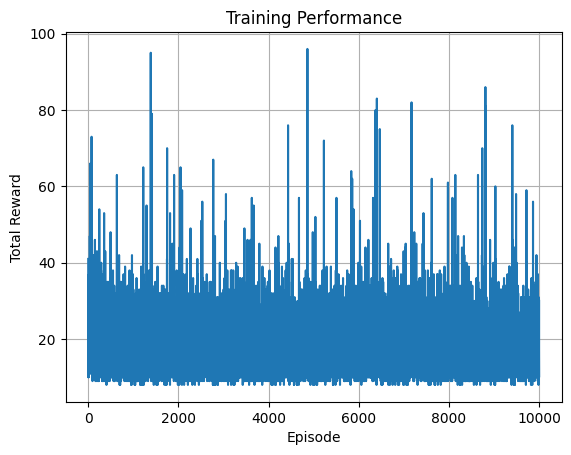

In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
alpha = 0.001  # Learning rate
gamma = 0.8  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 10000  # Total training episodes

# Initialize environment and parameters
env = gym.make("CartPole-v1")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Q-Table (discretized state space)
bins = [100, 100, 100, 100]  # Number of bins per state feature
state_bins = [
    np.linspace(-4.8, 4.8, bins[0] - 1),  # Cart position
    np.linspace(-4, 4, bins[1] - 1),  # Cart velocity
    np.linspace(-0.418, 0.418, bins[2] - 1),  # Pole angle
    np.linspace(-4, 4, bins[3] - 1),  # Pole velocity
]
Q = np.zeros(bins + [action_space])  # Q-table with dimensions [20 x 20 x 20 x 20 x 2]

# Helper functions
def discretize_state(state):
    """Convert continuous state into discrete bins."""
    indices = []
    for i in range(len(state)):
        indices.append(np.digitize(state[i], state_bins[i]))
    return tuple(indices)

# Training loop
rewards_per_episode = []
for episode in tqdm(range(episodes)):
    state = discretize_state(env.reset()[0])  # Get initial state
    total_reward = 0

    for t in range(500):  # Limit episode length
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(action_space)
        else:
            action = np.argmax(Q[state])

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value
        Q[state + (action,)] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state + (action,)]
        )

        # Update state and reward
        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track rewards
    rewards_per_episode.append(total_reward)

# Plot training performance
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid()
plt.show()

In [ ]:
# Test the trained policy
env = gym.make("CartPole-v1", render_mode="human")  # Enable rendering
state = discretize_state(env.reset()[0])  # Reset the new environment and get initial state
done = False
while not done:
    action = np.argmax(Q[state])  # Always exploit
    next_state, _, done, _, _ = env.step(action)  # Take the action
    state = discretize_state(next_state)  # Update the state


In [28]:
import logging

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

training_period = 250  # record the agent's episode every 250
num_training_episodes = 10_000  # total number of training episodes

env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env)

for episode_num in range(num_training_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

    logging.info(f"episode-{episode_num}", info["episode"])
env.close()

Moviepy - Building video /home/hsuhanjaya/Richard/notebook/rl/cartpole-agent/training-episode-0.mp4.
Moviepy - Writing video /home/hsuhanjaya/Richard/notebook/rl/cartpole-agent/training-episode-0.mp4



TypeError: must be real number, not NoneType